# Spam/Ham Message Classifier

I will be using a dataset from the UCI datasets.
The file we are using contains a collection of more than 5 thousand SMS phone messages. The data folder also conatins a readme file conating more information of the dataset

Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the enumerate call).

Using these labeled ham and spam examples, we'll train a machine learning model to learn to discriminate between ham/spam automatically. Then, with a trained model, we'll be able to classify arbitrary unlabeled messages as ham or spam.

link to dataset: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [37]:
#importing packages

import pandas as pd
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import unicodedata
import re
import spacy
import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

nlp = spacy.load('en', disable=['parser', 'ner'])

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siddhant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_messages =  pd.read_csv('F:/Datasets/SMSSpamCollection', sep = '\t', names = ['label','message'])
df_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

In [3]:
df_messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df_messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [5]:
#calculating the length of each message
df_messages['length'] = df_messages['message'].apply(len)
df_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


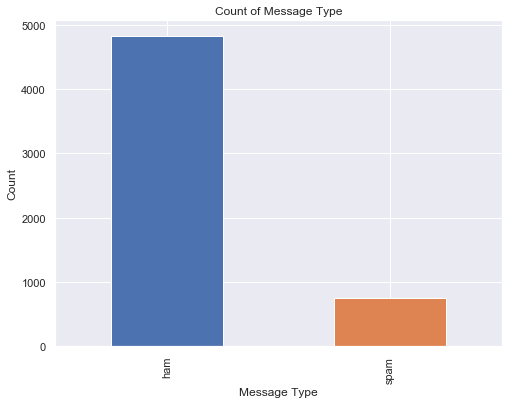

In [10]:
#counting the number of messages in Spam and Ham
sns.set()
plt.figure(figsize=(8,6))
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Count of Message Type')
df_messages.label.value_counts().plot.bar()

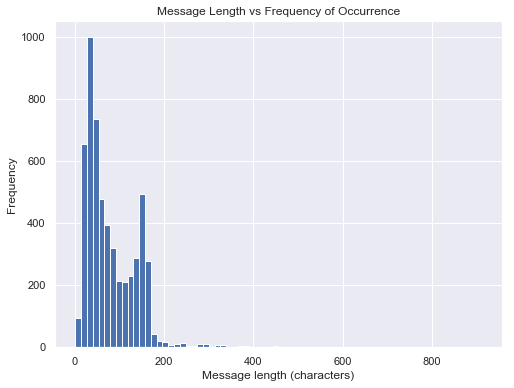

In [6]:
#message_length vs freq_of_occurence plot
sns.set()
plt.figure(figsize=(8,6))
plt.xlabel('Message length (characters)')
plt.ylabel('Frequency')
plt.title('Message Length vs Frequency of Occurrence')
df_messages['length'].plot(bins=70, kind='hist') 

In [7]:
df_messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001700808D5F8>,
      dtype=object)

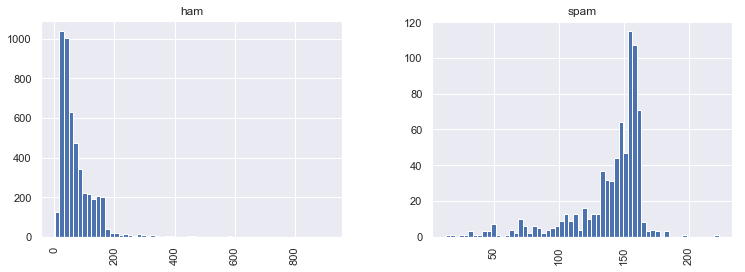

In [117]:
#legnth w.r.t ham and spam messages
df_messages.hist(column='length', by='label', bins=60,figsize=(12,4))


### WordCloud

In [9]:
data_ham  = df_messages[df_messages['label'] == 'ham']
data_spam = df_messages[df_messages['label'] == 'spam']

In [11]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

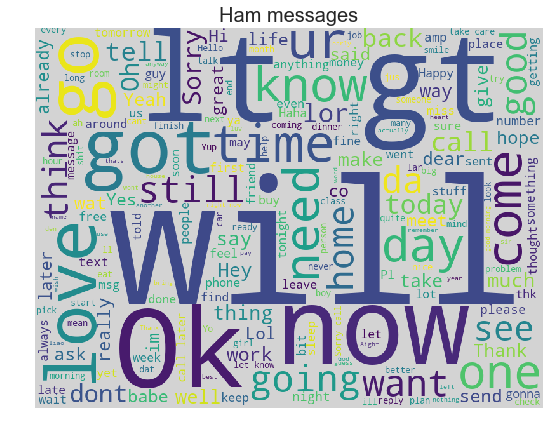

In [12]:
show_wordcloud(data_ham, "Ham messages")

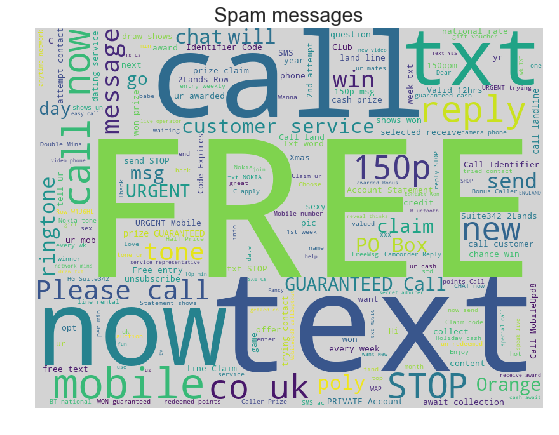

In [13]:
show_wordcloud(data_spam, "Spam messages")

## Text Normalization

We will normalize the text by removing the accented characters, special characters, punctuations, stop words, whitespaces and then lemmatize the words so that they can be converted into vectors.

Function to remove accented characters

In [15]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

Function to remove special characters

In [20]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

Function to lemmatize the text

In [16]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("The striped bats are hanging on their feet for best")

'the stripe bat be hang on their foot for good'

Text classifier function

In [21]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove accented characters
    3. Remove special characters
    4. Lemmatization
    5. Remove Extra whitespaces
    6. Remove all stopwords
    7. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    #Removing accented characters
    #acc_char = remove_accented_chars(nopunc)
    acc_char = unidecode.unidecode(nopunc)
    
    #Removing special charatcers and number
    special_number = remove_special_characters(acc_char, remove_digits = True)
    
    #Lemmatization
    lemm = lemmatize_text(special_number)
    
    #Remove extra whitespace
    doc = re.sub(' +', ' ', lemm)
    
    # Now just remove any stopwords
    return[word for word in doc.split() if word.lower() not in stopwords.words('english')]
    
    

In [22]:
df_messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [23]:
# Check to make sure its working
df_messages['message'].head(5).apply(text_process)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, Joking, wif, u, oni]
2    [free, entry, wkly, comp, win, FA, Cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, live, around, though]
Name: message, dtype: object

### Relevant words in Spam and Ham messages

In [24]:
data_ham.loc[:, 'message'] = data_ham['message'].apply(text_process)
words_data_ham = data_ham['message'].tolist()
data_spam.loc[:, 'message'] = data_spam['message'].apply(text_process)
words_data_spam = data_spam['message'].tolist()

C:\Users\Siddhant\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)
        
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)

c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

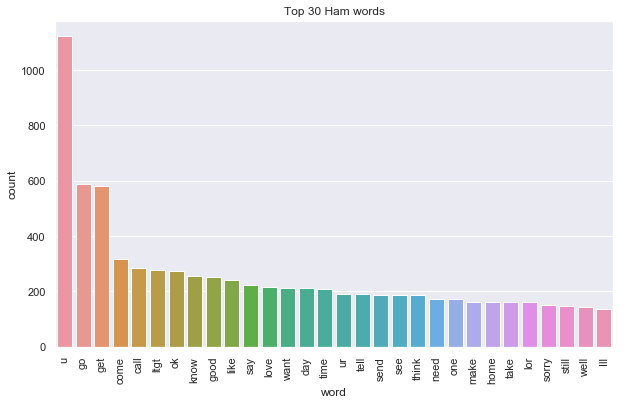

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical')

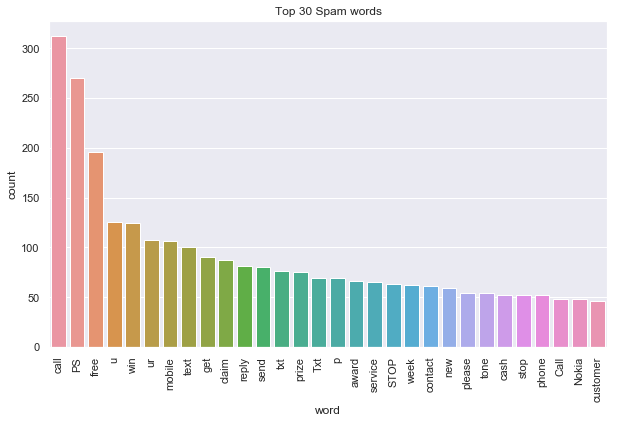

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

## Text Preprocessing

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in following steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

In [29]:
#countvectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_messages['message'])
print(len(bow_transformer.vocabulary_))

8749


In [30]:
messages_bow = bow_transformer.transform(df_messages['message'])
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 8749)
Amount of Non-Zero occurences:  46162


In [31]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


In [33]:
#tdif transformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 8749)


## Model Training

In [35]:
#train and test split
msg_train, msg_test, label_train, label_test = \
train_test_split(df_messages['message'], df_messages['label'], test_size=0.2)

## Naive bayes

In [36]:
from sklearn.naive_bayes import MultinomialNB

In [38]:
pipeline_nb = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [39]:
pipeline_nb.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001706442AD90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [40]:
predictions_nb = pipeline_nb.predict(msg_test)

In [41]:
print(classification_report(label_test,predictions_nb))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.74      0.85       150

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115



In [42]:
print(confusion_matrix(label_test,predictions_nb))

[[965   0]
 [ 39 111]]


In [43]:
accuracy_nb = accuracy_score(label_test, predictions_nb)
prec_spam_nb = precision_score(label_test, predictions_nb, pos_label="spam")
recall_spam_nb = recall_score(label_test, predictions_nb,pos_label="spam")
f1_spam_nb = f1_score(label_test, predictions_nb,pos_label="spam")
prec_ham_nb = precision_score(label_test, predictions_nb, pos_label="ham")
recall_ham_nb = recall_score(label_test, predictions_nb,pos_label="ham")
f1_ham_nb = f1_score(label_test, predictions_nb,pos_label="ham")

recall_spam_nb_avg = (recall_spam_nb+recall_ham_nb)/2
f1_spam_nb_avg = (f1_spam_nb+f1_ham_nb)/2

In [44]:
df_nb = pd.DataFrame({'Accuracy' : [accuracy_nb], 'Precision Score (spam)' : [prec_spam_nb],
                       'Precision Score (ham)' : [prec_ham_nb],'Recall Score':[recall_spam_nb_avg],
                       'F1 Score' : [f1_spam_nb_avg]}, index=[0])
df_nb = df_nb.melt()
df_nb.columns =['Attributes','NB']
df_nb['NB'] = round(df_nb['NB'],2)
df_nb

,Attributes,NB
0,Accuracy,0.97
1,Precision Score (spam),1.00
2,Precision Score (ham),0.96
3,Recall Score,0.87
4,F1 Score,0.92


## XG Boost

In [45]:
import xgboost as xgb
from xgboost import XGBClassifier

In [46]:
model = XGBClassifier().fit(messages_tfidf, df_messages['label'])

In [47]:
pipeline_xgb = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', XGBClassifier(learning_rate = 0.1, objective = 'binary:logistic',
                                    gamma = 1, max_depth = 10)),  # train on TF-IDF vectors w/ XGB classifier
])

In [48]:
pipeline_xgb.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001706442AD90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

In [49]:
predictions_xgb = pipeline_xgb.predict(msg_test)

In [51]:
print(classification_report(label_test,predictions_xgb))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       0.98      0.83      0.90       150

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



In [52]:
print(confusion_matrix(label_test,predictions_xgb))

[[963   2]
 [ 26 124]]


In [53]:
accuracy_xgb = accuracy_score(label_test, predictions_xgb)
prec_spam_xgb = precision_score(label_test, predictions_xgb, pos_label="spam")
recall_spam_xgb = recall_score(label_test, predictions_xgb,pos_label="spam")
f1_spam_xgb = f1_score(label_test, predictions_xgb,pos_label="spam")
prec_ham_xgb = precision_score(label_test, predictions_xgb, pos_label="ham")
recall_ham_xgb = recall_score(label_test, predictions_xgb,pos_label="ham")
f1_ham_xgb = f1_score(label_test, predictions_xgb,pos_label="ham")

recall_xgb_svm_avg = (recall_spam_xgb+recall_ham_xgb)/2
f1_spam_xgb_avg = (f1_spam_xgb+f1_ham_xgb)/2

In [54]:
df_xgb = pd.DataFrame({'Accuracy' : [accuracy_xgb], 'Precision Score (spam)' : [prec_spam_xgb],
                       'Precision Score (ham)' : [prec_ham_xgb],'Recall Score':[recall_xgb_svm_avg],
                       'F1 Score' : [f1_spam_xgb_avg]}, index=[0])
df_xgb = df_xgb.melt()
df_xgb.columns =['Attributes','XGB']
df_xgb['XGB'] = round(df_xgb['XGB'],2)
df_xgb

,Attributes,XGB
0,Accuracy,0.97
1,Precision Score (spam),0.98
2,Precision Score (ham),0.97
3,Recall Score,0.91
4,F1 Score,0.94


## Support Vector Machine

In [55]:
from sklearn.svm import SVC
#svm = SVC().fit(messages_tfidf, df_messages['label'])

In [56]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ Random Forest classifier
])

In [57]:
pipeline_svm.fit(msg_train,label_train)

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001706442AD90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [58]:
predictions_svm = pipeline_svm.predict(msg_test)

In [59]:
print(classification_report(predictions_svm,label_test))

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

         ham       1.00      0.87      0.93      1115
        spam       0.00      0.00      0.00         0

   micro avg       0.87      0.87      0.87      1115
   macro avg       0.50      0.43      0.46      1115
weighted avg       1.00      0.87      0.93      1115



In [60]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(label_test,predictions_svm))

[[965   0]
 [150   0]]


### Parameter Tunning for SVM

In [61]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf','poly']} 

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3).fit(messages_tfidf, df_messages['label'])

C:\Users\Siddhant\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.8692142088266954, total=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.8691437802907916, total=   0.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.8702207862143242, total=   0.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV]  C=0.1, gamma=1, kernel=poly, score=0.8659849300322928, total=   1.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV]  C=0.1, gamma=1, kernel=poly, score=0.8659127625201939, total=   1.2s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV]  C=0.1, gamma=1, kernel=poly, score=0.8659127625201939, total=   1.3s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.8659849300322928, total=   0.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.8659127625201939, total=   0.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.86591276

[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8659849300322928, total=   0.3s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8659127625201939, total=   0.3s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.8659127625201939, total=   0.3s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.9703982777179763, total=   1.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.9671513193322563, total=   1.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV]  C=10, gamma=1, kernel=rbf, score=0.9709208400646203, total=   1.0s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV]  C=10, gamma=1, kernel=poly, score=0.9397201291711518, total=   1.3s
[CV] C=10, gamma=1, kernel=poly ...............

[CV] C=100, gamma=0.001, kernel=poly .................................
[CV]  C=100, gamma=0.001, kernel=poly, score=0.8659127625201939, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.8659849300322928, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.8659127625201939, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.8659127625201939, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV]  C=100, gamma=0.0001, kernel=poly, score=0.8659849300322928, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV]  C=100, gamma=0.0001, kernel=poly, score=0.8659127625201939, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV]  C=100, gamma=0.0001, 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.6min finished


In [65]:
#best parameters
grid.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [66]:
pipeline_svm_grid = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC(C= 100, gamma = 0.01, kernel = 'rbf')),  # train on TF-IDF vectors w/ Random Forest classifier
])

In [67]:
pipeline_svm_grid.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001706442AD90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [68]:
predictions_svm_grid = pipeline_svm_grid.predict(msg_test)

In [69]:
print(classification_report(label_test,predictions_svm_grid))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       965
        spam       0.98      0.92      0.95       150

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [70]:
print(confusion_matrix(label_test,predictions_svm_grid))

[[962   3]
 [ 12 138]]


In [71]:
accuracy_svm = accuracy_score(label_test, predictions_svm_grid)
prec_spam_svm = precision_score(label_test, predictions_svm_grid, pos_label="spam")
recall_spam_svm = recall_score(label_test, predictions_svm_grid,pos_label="spam")
f1_spam_svm = f1_score(label_test, predictions_svm_grid,pos_label="spam")
prec_ham_svm = precision_score(label_test, predictions_svm_grid, pos_label="ham")
recall_ham_svm = recall_score(label_test, predictions_svm_grid,pos_label="ham")
f1_ham_svm = f1_score(label_test, predictions_svm_grid,pos_label="ham")

recall_spam_svm_avg = (recall_spam_svm+recall_ham_svm)/2
f1_spam_svm_avg = (f1_spam_svm+f1_ham_svm)/2

In [72]:
df_svm = pd.DataFrame({'Accuracy' : [accuracy_svm], 'Precision Score (spam)' : [prec_spam_svm],
                       'Precision Score (ham)' : [prec_ham_svm],'Recall Score':[recall_spam_svm_avg],
                       'F1 Score' : [f1_spam_svm_avg]}, index=[0])
df_svm = df_svm.melt()
df_svm.columns =['Attributes','SVM']
df_svm['SVM'] = round(df_svm['SVM'],2)
df_svm

,Attributes,SVM
0,Accuracy,0.99
1,Precision Score (spam),0.98
2,Precision Score (ham),0.99
3,Recall Score,0.96
4,F1 Score,0.97


## Model Evaluation

In [73]:
#combined dataframe of all the models
df_merged = df_nb
df_merged['XGB'] = df_xgb['XGB']
df_merged['SVM'] = df_svm['SVM']
df_merged

,Attributes,NB,XGB,SVM
0,Accuracy,0.97,0.97,0.99
1,Precision Score (spam),1.00,0.98,0.98
2,Precision Score (ham),0.96,0.97,0.99
3,Recall Score,0.87,0.91,0.96
4,F1 Score,0.92,0.94,0.97


In [74]:
df_merged_tr = df_merged.transpose()
new_header = df_merged_tr.iloc[0] #grab the first row for the header
df_merged_tr = df_merged_tr[1:] #take the data less the header row
df_merged_tr.columns = new_header #set the header row as the df header

df_merged_tr = df_merged_tr.reset_index()
df_merged_melt = pd.melt(df_merged_tr, id_vars=['index'])
df_merged_melt.columns = ['model','attributes','Value']
df_merged_acc_f1 = df_merged_melt[(df_merged_melt['attributes'] == 'Accuracy') | (df_merged_melt['attributes'] == 'F1 Score')]

<Figure size 864x864 with 0 Axes>

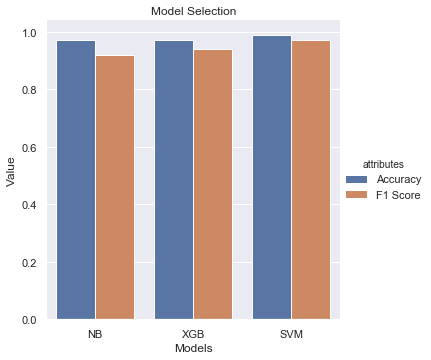

In [77]:
#plotting the accuracy and f1 score
#SVM is the winner
plt.figure(figsize=(12,12))
ax = sns.catplot(x='model', y='Value', hue='attributes', data=df_merged_acc_f1, kind='bar')
ax.set(xlabel='Models', ylabel='Value', title = 'Model Selection')
plt.show()

In [78]:
def str_to_bin(text):
    df = pd.DataFrame(text)
    df.columns = ['value']
    df['value']=df['value'].map( {'spam': 1, 'ham': 0} ).astype(int)
    return df

In [79]:
label_bin = label_test.map( {'spam': 1, 'ham': 0} ).astype(int)
predictions_nb_bin = str_to_bin(predictions_nb)
predictions_xgb_bin = str_to_bin(predictions_xgb)
predictions_svm_bin = str_to_bin(predictions_svm_grid)

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

fpr_nb, tpr_nb, thresh_nb = metrics.roc_curve(label_bin,predictions_nb_bin)
auc_nb = metrics.roc_auc_score(label_bin,predictions_nb_bin)

fpr_xgb, tpr_xgb, thresh_xgb = metrics.roc_curve(label_bin,predictions_xgb_bin)
auc_xgb = metrics.roc_auc_score(label_bin,predictions_xgb_bin)

fpr_svm, tpr_svm, thresh_svm = metrics.roc_curve(label_bin,predictions_svm_bin)
auc_svm = metrics.roc_auc_score(label_bin,predictions_svm_bin)

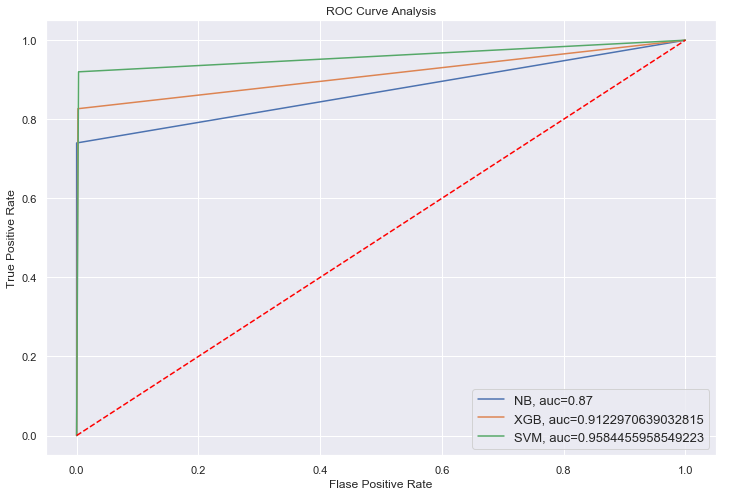

In [118]:
#roc curve
plt.figure(figsize=(12,8))
plt.plot(fpr_nb,tpr_nb,label="NB, auc="+str(auc_nb))
plt.plot(fpr_xgb,tpr_xgb,label="XGB, auc="+str(auc_xgb))
plt.plot(fpr_svm,tpr_svm,label="SVM, auc="+str(auc_svm))
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("Flase Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve Analysis')
plt.legend(prop={'size':13}, loc='lower right')

## Spam/Ham Classifier Widget

A widget where you can enter the message and it will tell you whether the message is a spam/ham.
Since SVM is the best model as per analysis. I will be using the SVM in the backend to classify whether the message is a spam/ham.

In [82]:
def spam_ham_classifier(text):
    prediction = pipeline_svm_grid.predict(text)[0]
    return prediction

In [107]:
from tkinter import * 
import tkinter as tk
 
root = Tk()

def returnEntry(arg=None):
    result = myEntry.get()
    result = [result]
    pred = spam_ham_classifier(result)
    resultLabel.config(text=pred)
    myEntry.delete(0,END)


# Create the Entry widget
myEntry = Entry(root, width=500)
myEntry.focus()
myEntry.bind("<Return>",returnEntry)
myEntry.pack()
 
# Create the Enter button
enterEntry = Button(root, text= "Spam/Ham", command=returnEntry)
enterEntry.pack(fill=X)
 
# Create and empty Label to put the result in
resultLabel = Label(root, text = "")
resultLabel.pack(fill=X)
 
#root.geometry("+750+400")
root.geometry("500x70+600+400")
root.title("Spam/Ham Classifier")
 
root.mainloop()